In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import mord # für ordinal logit model

#conda install -c ericdill mord

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression


import warnings
warnings.filterwarnings("ignore")

## Overview Rating Grades

https://www.lendingclub.com/foliofn/rateDetail.action

### Read in the data

In [3]:
df_orig = pd.read_csv('LendingClub_short.csv', low_memory=False)
df=df_orig.copy()
print(df.shape)
df.head()

# ich habe 50000 Zeile und 41 Spalte

# member_id muss gelöscht werden (Daten sind anonymisiert)
# loan_amnt was ich haben wollte , funded_amnt was ich bekomme
# int_rate ist Zinse
# installment wie viel zahle ich mönatlich zurück
# emp_title ist Beruf der Kreditnehmer

(50000, 41)


,Unnamed: 0,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,emp_title,emp_length,...,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog
0,1600208,NaN,14000,14000,14000.0,16.02,492.34,C,Bookkeeper,< 1 year,...,9366.620000,9366.62,6441.55,2900.45,24.62,0.0,0.0,1009.30,0.0,NaN
1,1121981,NaN,28000,28000,28000.0,21.99,773.18,F,physician,10+ years,...,39373.212331,39373.21,28000.00,11373.21,0.00,0.0,0.0,20885.30,0.0,NaN
2,1923218,NaN,24000,24000,24000.0,10.99,521.70,B,Director of Business Strategy,1 year,...,29329.558978,29329.56,24000.00,5329.56,0.00,0.0,0.0,14214.91,0.0,NaN
3,526168,NaN,3000,3000,3000.0,13.99,102.52,C,Customer Loyalty Representative III,3 years,...,3432.207786,3432.21,3000.00,432.21,0.00,0.0,0.0,2101.78,0.0,NaN
4,1809377,NaN,10000,10000,10000.0,15.80,350.59,C,mendocino coast district hospital,9 years,...,12620.953324,12620.95,10000.00,2620.95,0.00,0.0,0.0,350.30,0.0,76.0


### Find NaNs

In [4]:
# Nicht gefüllte Spalten müssen entwernt werden! oder wechseln

def null_values(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
    
miss_values = null_values(df)
miss_values.head(25)

# dti bedeutet: Rate im Vergeich zu Loan- je höher dieser Wert ist, desto länger braucht man zurückzuzahlen

Dataframe has 41 columns.
There are 16 columns that have missing values.


,Missing Values,% of Total Values
member_id,50000,100.0
url,50000,100.0
mths_since_last_record,42113,84.2
mths_since_last_major_derog,37168,74.3
mths_since_last_delinq,25561,51.1
emp_title,3710,7.4
emp_length,3254,6.5
title,531,1.1
dti,45,0.1
revol_util,37,0.1


### Drop unimportant or missing features

In [5]:
# Für Datenauswertung müssen wir ein paar Sachen rausscheißen
df.drop(['member_id','url','mths_since_last_record', 'mths_since_last_major_derog',
         'mths_since_last_delinq' ,'emp_title', 'loan_status','pymnt_plan','title','revol_bal',
         'out_prncp_inv','total_pymnt_inv','total_rec_late_fee','recoveries','collection_recovery_fee',
         'collections_12_mths_ex_med','Unnamed: 0','funded_amnt_inv','total_rec_prncp','total_rec_int',
         'last_pymnt_amnt','initial_list_status','loan_amnt','funded_amnt'],axis=1,inplace=True)
df.dropna(inplace=True)



In [6]:
df.head() # mit dieser Data Frame beschäftigen wir uns!

,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,out_prncp,total_pymnt
0,16.02,492.34,C,< 1 year,RENT,55000.0,Source Verified,credit_card,15.80,0.0,0.0,18.0,0.0,79.6,25.0,7558.45,9366.620000
1,21.99,773.18,F,10+ years,MORTGAGE,500000.0,Verified,debt_consolidation,7.31,0.0,0.0,20.0,2.0,84.0,33.0,0.00,39373.212331
2,10.99,521.70,B,1 year,MORTGAGE,165000.0,Source Verified,debt_consolidation,8.03,1.0,0.0,10.0,0.0,14.8,19.0,0.00,29329.558978
3,13.99,102.52,C,3 years,RENT,40000.0,Verified,debt_consolidation,29.28,0.0,0.0,8.0,0.0,64.4,10.0,0.00,3432.207786
4,15.80,350.59,C,9 years,OWN,50000.0,Not Verified,credit_card,18.91,0.0,1.0,10.0,0.0,39.6,13.0,0.00,12620.953324


### Feature Analysis

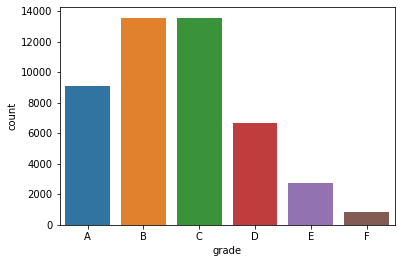

In [7]:
# Anzahl die Beobachtungen je Rating Klasse

sns.countplot(df["grade"], order="A B C D E F".split())

#### Metric Features

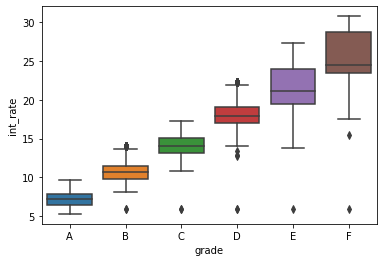

In [8]:
# dti bedeutet: Rate im Vergeich zu Loan- je höher dieser Wert ist, desto länger braucht man zurückzuzahlen
# je höher Grade ist, desto höher ist Risiko -> weil Zins ist eine Approximation von Risiko (Zins ist Bepresien der Risiko)

sns.boxplot(df['grade'],df['int_rate'],order="A B C D E F".split())

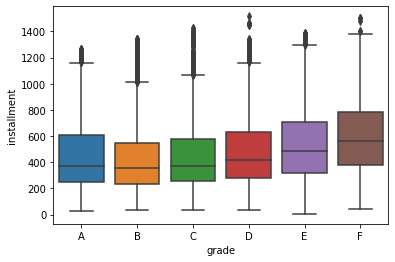

In [9]:
sns.boxplot(df['grade'],df['installment'],order="A B C D E F".split())
# je länger die Laufzeit, desto kleiner ist die Rate Risiko oder je kleiner mein Kredit ist, desto kleiner meine Rate auch

#### Categorical Features

In [10]:
# Length of Employment
df['emp_length'].value_counts()

10+ years    16584
2 years       4503
< 1 year      4088
3 years       4023
1 year        3283
5 years       3163
4 years       3014
6 years       2242
7 years       2038
8 years       1980
9 years       1788
Name: emp_length, dtype: int64

In [11]:
# Living Situation -> die Wohnung der Kreditnehmer
df['home_ownership'].value_counts()
# Mortage er ist Haus finanziert! auf Deutsch bedeutet: Hypothek
# Rent= Miete
# Own Kreditnehmer hat eigene Wohnung
# Any , Other, None werden wir rausschmeißen

MORTGAGE    23261
RENT        18500
OWN          4921
ANY            20
NONE            2
OTHER           2
Name: home_ownership, dtype: int64

In [12]:
#Verification status of account - es geht um Gehalt! ist es Einkommen gesichert?
df['verification_status'].value_counts()

Source Verified    18890
Not Verified       15598
Verified           12218
Name: verification_status, dtype: int64

In [13]:
#Purpose of credit -> warum nehmen Leute Kredite auf?
df['purpose'].value_counts()


debt_consolidation    26352
credit_card           10808
home_improvement       3025
other                  2834
major_purchase         1094
small_business          553
car                     526
medical                 496
moving                  324
vacation                313
house                   284
wedding                  56
renewable_energy         32
educational               9
Name: purpose, dtype: int64

## Data Preprocessing
### man wandelt diese Strings der qualitativen Merkmale zum ersten Schritt meine Zahlen um -> und dann in Dummies (alles was ich definiert habe, werden  wir später Dummy kodieren -> d.h wir werden für jedes Eintrag außer der Referenzkategorie eine Spalte definieren, die entweder 0 oder 1 ist!


In [15]:
# Redifine employment length
# wir müssen ein Referenzkategorie wählen -> ich nehme immer die schlechteste/untenteste -> Referenzkategorie ist immer 0 !

df['emp_length'][df['emp_length']=='< 1 year']=0 # ist Referenz Kategorie


df['emp_length'][df['emp_length']=='1 year']=1
df['emp_length'][df['emp_length']=='2 years']=2
df['emp_length'][df['emp_length']=='3 years']=3
df['emp_length'][df['emp_length']=='4 years']=4
df['emp_length'][df['emp_length']=='5 years']=5
df['emp_length'][df['emp_length']=='6 years']=6
df['emp_length'][df['emp_length']=='7 years']=7
df['emp_length'][df['emp_length']=='8 years']=8
df['emp_length'][df['emp_length']=='9 years']=9
df['emp_length'][df['emp_length']=='10+ years']=10

# wir werden später Dummy kodieren -> d.h wir werden für jedes Eintrag außer der Referenzkategorie eine Spalte definieren, die entweder 0 oder 1 ist!

In [16]:
#Redefine living situation and delete minor categories

df['home_ownership'][df['home_ownership']=='MORTGAGE']=0 # Referenz Kategorie ist Mortagage(=Hypothek)
df['home_ownership'][df['home_ownership']=='RENT']=1
df['home_ownership'][df['home_ownership']=='OWN']=2

# letzte 3 Zeile scheißen wir rauß!
df=df[df['home_ownership']!='ANY']   
df=df[df['home_ownership']!='OTHER']
df=df[df['home_ownership']!='NONE']

In [17]:
# Redefine verification status
df['verification_status'][df['verification_status']=='Source Verified']=0 # Referenz Kategorie
df['verification_status'][df['verification_status']=='Not Verified']=1
df['verification_status'][df['verification_status']=='Verified']=2

In [18]:
# Redefine purpose of credit

df['purpose'][df['purpose']=='debt_consolidation']=0 # Referenz Kategorie
df['purpose'][df['purpose']=='credit_card']=1
df['purpose'][df['purpose']=='home_improvement']=2
df['purpose'][df['purpose']=='major_purchase']=3
df['purpose'][df['purpose']=='small_business']=4
df['purpose'][df['purpose']=='car']=5
df['purpose'][df['purpose']=='medical']=6
df['purpose'][df['purpose']=='moving']=7
df['purpose'][df['purpose']=='vacation']=8
df['purpose'][df['purpose']=='house']=9
df['purpose'][df['purpose']=='wedding']=10
df['purpose'][df['purpose']=='renewable_energy']=11
df['purpose'][df['purpose']=='educational']=12
df['purpose'][df['purpose']=='other']=13

### Encode Categorical Features

In [19]:
# wir werden später Dummy kodieren -> d.h wir werden für jedes Eintrag außer der Referenzkategorie eine Spalte definieren, die entweder 0 oder 1 ist!
# drop_first: schmeißt erste Spalte raus (die als 0 definiert, weil ich nur k-1 kategoriale Variable in meinem Modell reinnehmen)

df_dummies=pd.get_dummies(df[['emp_length','home_ownership','verification_status','purpose']],drop_first=True)
Dummy_names=['1year 2years 3years 4years 5years 6years 7years 8years 9years +10years Rent Own NotVerified Verified'.split()+
                    'credit_card home_improvement major_purchase small_business car medical moving vacation house wedding renewable_energy educational other'.split()][0]
df_dummies.columns=Dummy_names

In [20]:
df_dummies.head()

# ich habe für jede kategoriale Variable ein Dummy definiert
# sieht unsere Dummy Matrix genau so aus-> 
# z.B erste Teil ist employment_length: ich habe für jede Zeitscheibe eine Spalte definiert 1year,2year,3year,+10year -> diese Spalte enthalt entweder 1 oder 0
# 

,1year,2years,3years,4years,5years,6years,7years,8years,9years,+10years,...,small_business,car,medical,moving,vacation,house,wedding,renewable_energy,educational,other
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Get Final Dataframe

In [21]:
# merge out data
# wir sollen nicht nur katgeoriale Variable hernehmen sonder die metrischen Variable auch
# merge unsere Datensatz wieder zusammen

Final_Data=pd.concat([df.drop(['emp_length','home_ownership','verification_status','purpose'],axis=1),df_dummies],axis=1)

In [22]:
Final_Data.head()

# ich habe 40 Spalten -> 40 Variable, die ich für meine Modelle verwenden kann -> relativ viel Anzahl an Variable! -> Regularizierung könnte dabei helfen, diese Variable weniger zu machen, damit Modell besser laufen!

,int_rate,installment,grade,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,...,small_business,car,medical,moving,vacation,house,wedding,renewable_energy,educational,other
0,16.02,492.34,C,55000.0,15.80,0.0,0.0,18.0,0.0,79.6,...,0,0,0,0,0,0,0,0,0,0
1,21.99,773.18,F,500000.0,7.31,0.0,0.0,20.0,2.0,84.0,...,0,0,0,0,0,0,0,0,0,0
2,10.99,521.70,B,165000.0,8.03,1.0,0.0,10.0,0.0,14.8,...,0,0,0,0,0,0,0,0,0,0
3,13.99,102.52,C,40000.0,29.28,0.0,0.0,8.0,0.0,64.4,...,0,0,0,0,0,0,0,0,0,0
4,15.80,350.59,C,50000.0,18.91,0.0,1.0,10.0,0.0,39.6,...,0,0,0,0,0,0,0,0,0,0


### Train-Test-Split

In [23]:
# Was wir machen müssen, um Bias-Variance Trade-Off gerecht werden ist Splitten Train und Test Daten

X_train, X_test, y_train, y_test = train_test_split(Final_Data.drop('grade',axis=1),Final_Data['grade'],test_size=0.35,random_state=245)

### Scale Metric Variables

In [24]:
# Use the same standardization for train and test sample!!! 
# wir haben unterschiedlich Dimensionen bspw. delinq_2yrs und annual_inc haben unterschiedliche Range
# wenn man Regularizierung (L1 oder L2) anwenden möchte, müsste man unbedingt diese Variable standardisiert
# -> d.h: alle metrische Variable, die ich habe, auf gleiche Dimension bekommen (= standardisieren)

sc = StandardScaler().fit(X_train.drop(Dummy_names,axis=1))

# man muss aufpassen! 
# wir skalieren train-Variable und test-Variable nicht separat!
X_train_scaled=pd.DataFrame(sc.transform(X_train.drop(Dummy_names,axis=1)),columns=X_train.drop(Dummy_names,axis=1).columns.values)
X_test_scaled=pd.DataFrame(sc.transform(X_test.drop(Dummy_names,axis=1)),columns=X_test.drop(Dummy_names,axis=1).columns.values)

X_train=pd.concat([X_train_scaled.reset_index(), pd.DataFrame(X_train[Dummy_names]).reset_index()],axis=1).drop('index',axis=1)
X_test=pd.concat([X_test_scaled.reset_index(), pd.DataFrame(X_test[Dummy_names]).reset_index()],axis=1).drop('index',axis=1)

y_train=y_train.reset_index().drop('index',axis=1)
y_test=y_test.reset_index().drop('index',axis=1)

In [26]:
# Nach Standardisierung, sieht unsere DatenFrame so aus -> Werte sind jetzt standard-normal verteilt (Mittelwert über die Spalte sollte 0 sein + Standardabweichung innerhalb von der Spalte sollte ungefähr 1 sein)
X_train.head()


,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,...,small_business,car,medical,moving,vacation,house,wedding,renewable_energy,educational,other
0,-1.058012,-0.281167,-0.258061,-0.072286,-0.359263,-0.659359,0.405478,-0.351727,-1.333213,-0.189716,...,0,0,0,0,0,0,0,0,0,0
1,0.293969,0.240928,-0.421656,-0.466269,3.045560,-0.659359,-0.304308,-0.351727,0.071874,-0.937999,...,0,0,0,0,0,0,0,0,0,0
2,-1.324249,-0.536297,-0.560734,-0.701375,-0.359263,-0.659359,-1.014093,-0.351727,0.476798,-1.187427,...,0,0,0,0,0,0,0,0,0,0
3,-0.080425,0.842458,0.750849,-0.008093,-0.359263,-0.659359,2.179943,-0.351727,1.343335,2.055135,...,0,0,0,0,0,0,0,0,0,0
4,0.397968,0.975345,0.561679,-0.537683,-0.359263,-0.659359,-0.836647,-0.351727,2.084346,-0.605429,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# y_train ist im Endeffekt unser Rating -> wir versuchen aus dem ganzen X hier oben in der DatenFrame haben irgenwie die y gut vorhersagen!

y_train.head() 

,grade
0,A
1,C
2,A
3,C
4,C


## Wir fangen mit Multinomial Logit Model an
### ist im Endeffekt nicht anders als sequenzielles Logit hinterher!

## Estimate the Multinomial Logit Model

In [28]:
# nicht anders als sequenzeille Logit Modell
# Problem weil ich 40 Variable und 7 Ratingstufen(= 6 Kategorien, die ich schätzen muss!) haben -> das bedeutet ich muss 6*40 = 240 Parameter, die Multinomiale Logit schätzen sollte

MultinomialLogit = sm.MNLogit(y_train, X_train).fit(method='lbfgs',maxiter=1000)

#In and out of sample prediction
Prediction_MNLogit_InSample=MultinomialLogit.predict(X_train).idxmax(axis=1).map({0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:"G"})
Prediction_MNLogit_OutSample=MultinomialLogit.predict(X_test).idxmax(axis=1).map({0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:"G"})

print(MultinomialLogit.summary())

# A ist die Referenz Kategorie
# grade=B: man sieht hier die Koeffizienten die B Ratingklasse geschätzt haben
# ich sehe für jede Kategorie die Schätzwerte von unseren Koeffizienten 
# Inerpetation ist einbisschen schwierig, weil ich 40 Variable interpretieren 
# p-Values sind vielen davon nahe 0 

                          MNLogit Regression Results                          
Dep. Variable:                  grade   No. Observations:                30343
Model:                        MNLogit   Df Residuals:                    30109
Method:                           MLE   Df Model:                          228
Date:                Wed, 05 Feb 2020   Pseudo R-squ.:                  0.6635
Time:                        21:49:19   Log-Likelihood:                -16156.
converged:                       True   LL-Null:                       -48005.
Covariance Type:            nonrobust   LLR p-value:                     0.000
         grade=B       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
int_rate             6.6020      0.111     59.599      0.000       6.385       6.819
installment         -0.6407      0.070     -9.137      0.000      -0.778      -0.503
annual_inc           0.0148 

### Jetzt schauen wir den Fit an (wichtiger für uns)
### In Sample Fit

In [29]:
print('Accuracy MNLogit In Sample: \n', accuracy_score(y_train,Prediction_MNLogit_InSample),'\n\n')
print('Classification Report MNLogit In Sample: \n\n',classification_report(y_train ,Prediction_MNLogit_InSample),'\n\n')
print('Confusion Matrix MNLogit In Sample: \n\n',confusion_matrix(y_train, Prediction_MNLogit_InSample))

# Accuracy ist die Anzahl richtig vorhergesagten Ratingrate -> unsere Modell ist relativ gut
# f1-score: A-Rating kann ich gut vorhersagen
# f1-score: G-Rating kann ich leider schlecht vorhersagen (wegen kleiner Support)

# Confusion Matrix: wenn alle Werte nur auf Hauptdiagonale sind (von links-oben nach recht-unten) habe ich die Perfekte Zuordnung
# Es sieht schon einigermaßen gutes Modell -> erkennt die Ratingsklasse relativ gut 

Accuracy MNLogit In Sample: 
 0.7909237715453317 


Classification Report MNLogit In Sample: 

               precision    recall  f1-score   support

           A       0.82      0.90      0.86      5855
           B       0.85      0.80      0.83      8827
           C       0.86      0.84      0.85      8778
           D       0.70      0.76      0.73      4384
           E       0.49      0.49      0.49      1796
           F       0.25      0.17      0.20       541
           G       0.05      0.02      0.03       162

    accuracy                           0.79     30343
   macro avg       0.57      0.57      0.57     30343
weighted avg       0.79      0.79      0.79     30343
 


Confusion Matrix MNLogit In Sample: 

 [[5298  557    0    0    0    0    0]
 [1133 7067  620    6    0    1    0]
 [  30  669 7335  616   55   46   27]
 [   1    1  599 3318  366   67   32]
 [   0    0    8  764  884  125   15]
 [   1    0    0   35  405   93    7]
 [   1    0    0    2  110   45    4]

### Out of Sample Fit
#### sieht relativ gleich-> ich habe gleiche Problem bei der schlechten Ratingklasse "G"

In [30]:
print('Accuracy MNLogit Out of Sample: \n', accuracy_score(y_test,Prediction_MNLogit_OutSample),'\n\n') 
print('Classification Report MNLogit Out of Sample: \n\n',classification_report(y_test ,Prediction_MNLogit_OutSample),'\n\n') 
print('Confusion Matrix MNLogit Out of Sample: \n\n',confusion_matrix(y_test, Prediction_MNLogit_OutSample))  

Accuracy MNLogit Out of Sample: 
 0.788481547218312 


Classification Report MNLogit Out of Sample: 

               precision    recall  f1-score   support

           A       0.82      0.91      0.87      3231
           B       0.85      0.79      0.82      4723
           C       0.85      0.84      0.85      4750
           D       0.69      0.74      0.71      2297
           E       0.46      0.47      0.46       950
           F       0.24      0.18      0.21       297
           G       0.11      0.07      0.08        91

    accuracy                           0.79     16339
   macro avg       0.58      0.57      0.57     16339
weighted avg       0.79      0.79      0.79     16339
 


Confusion Matrix MNLogit Out of Sample: 

 [[2945  286    0    0    0    0    0]
 [ 613 3750  358    0    0    2    0]
 [  13  355 3988  325   33   22   14]
 [   1    1  318 1698  213   47   19]
 [   1    0    4  421  443   69   12]
 [   0    0    1   18  219   53    6]
 [   0    0    0    4   54

## Estimate the Ordered Logit Model

In [31]:
# Rating ist klassische Besipiel, wo ich Ordinales Model hernehmen kann
# wir schätzen Orderd Logit Model
# als Referenz Kategorie ist A und schlechteste G -> 
# d.h y* ist nicht die Bonität sondern das Risiko vom Schuld/ umgekehrte Bonität
# je höher y* ist ,desto schlechter ist mein Kreditnehmer

y_train_OL=pd.DataFrame(y_train['grade'].map({"A":0,"B":1,"C":2,"D":3,"E":4,"F":5,"G":6}))
y_test_OL=pd.DataFrame(y_test['grade'].map({"A":0,"B":1,"C":2,"D":3,"E":4,"F":5,"G":6}))

ord_Logit = mord.LogisticAT(alpha =0,verbose=1)
ord_Logit.fit(np.asarray(X_train), np.asarray(y_train_OL).reshape(len(y_train_OL),))


Prediction_ORLogit_InSample=pd.Series(ord_Logit.predict(np.asarray(X_train))).map({0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:"G"})
Prediction_ORLogit_OutSample=pd.Series(ord_Logit.predict(np.asarray(X_test))).map({0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:"G"})

print(pd.concat([pd.DataFrame(X_train.columns),
pd.DataFrame(ord_Logit.coef_) ], axis=1))

# je höher int_rate ist, desto höhe die Wahrscheinlichkeit dass schlechteste Rating Klasse einkommt 
# A und B können Wir interpretieren aber was kommt dazwischen nicht klar 
# dti je höher ist, desto höher die Wahrscheinlichkeit dass schlechteste Rating Klasse einkommt


                   0         0
0           int_rate  8.751106
1        installment -0.364282
2         annual_inc -0.050906
3                dti  0.066931
4        delinq_2yrs  0.056775
5     inq_last_6mths  0.136507
6           open_acc  0.019249
7            pub_rec  0.100716
8         revol_util  0.193477
9          total_acc -0.004336
10         out_prncp -0.209528
11       total_pymnt  0.626063
12             1year -0.009551
13            2years -0.027145
14            3years  0.091261
15            4years -0.057923
16            5years -0.170751
17            6years -0.148909
18            7years -0.076058
19            8years  0.111407
20            9years -0.224140
21          +10years -0.062204
22              Rent  0.097901
23               Own  0.115060
24       NotVerified -0.185166
25          Verified -0.140589
26       credit_card -0.179775
27  home_improvement  0.009970
28    major_purchase  0.066285
29    small_business  0.904500
30               car -0.004803
31      

### Plot the Distribution of the latent Variable

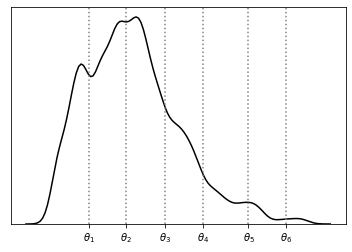

In [30]:
# Verteilung von latente Variable -> Verteilung von y*
y_star= X_train@ord_Logit.coef_



figure = sns.distplot(y_star , hist=False ,color='black')
figure.set_xticks((ord_Logit.theta_))
figure.set_xticklabels((r'$\theta_ {1}$', r'$\theta_2$', r'$\theta_3$', r'$\theta_4$'
                        , r'$\theta_5$', r'$\theta_6$'))
figure.set_yticks ([])
figure.axvline(ord_Logit.theta_[0], 0, 1, linestyle="dotted",color='grey')
figure.axvline(ord_Logit.theta_[1], 0, 1, linestyle="dotted",color='grey')
figure.axvline(ord_Logit.theta_[2], 0, 1, linestyle="dotted",color='grey')
figure.axvline(ord_Logit.theta_[3], 0, 1, linestyle="dotted",color='grey')
figure.axvline(ord_Logit.theta_[4], 0, 1, linestyle="dotted",color='grey')
figure.axvline(ord_Logit.theta_[5], 0, 1, linestyle="dotted",color='grey')

### In Sample Fit

In [32]:
print('Accuracy ORLogit In Sample: \n', accuracy_score(y_train,Prediction_ORLogit_InSample),'\n\n')
print('Classification Report ORLogit In Sample: \n\n',classification_report(y_train ,Prediction_ORLogit_InSample),'\n\n')
print('Confusion Matrix ORLogit In Sample: \n\n',confusion_matrix(y_train, Prediction_ORLogit_InSample))

# Man sieht hier im Vergleich zu Multinomial Logit Model, dass ich 0.846 Accuracy
# d.h ordinale Prozss, die ich in meinem Modell unterstellt, triff anscheined die RatingPhilosophie(=wie die Rating zustande kommt) relativ gut/besser als Multinomial Logit!
# Die Unterschied kann man sehen durch f1-socre! -> ist höher als Multinomial Logit -> Ordered Logit teifft auch diese schlechten Ratingklasse "G" einbisschen besser!
# das liegt daran, dass Ordered Logit weniger Parameter schätzen muss 

# ordinales Przess trifft empirschen Daten besser
# bei Confusion Matrix  man kann gut diskriminieren -> also gut unterscheiden zwischen gut und schlecht

Accuracy ORLogit In Sample: 
 0.8469498731173583 


Classification Report ORLogit In Sample: 

               precision    recall  f1-score   support

           A       0.92      0.95      0.93      5855
           B       0.89      0.87      0.88      8827
           C       0.87      0.89      0.88      8778
           D       0.79      0.79      0.79      4384
           E       0.58      0.53      0.55      1796
           F       0.33      0.32      0.32       541
           G       0.43      0.44      0.44       162

    accuracy                           0.85     30343
   macro avg       0.69      0.68      0.69     30343
weighted avg       0.85      0.85      0.85     30343
 


Confusion Matrix ORLogit In Sample: 

 [[5545  310    0    0    0    0    0]
 [ 487 7697  643    0    0    0    0]
 [   1  640 7803  334    0    0    0]
 [   1    0  501 3460  422    0    0]
 [   0    0    7  560  949  280    0]
 [   1    0    0    5  268  174   93]
 [   1    0    0    2    7   81   71]

### Out of Sample Fit

In [33]:
print('Accuracy ORLogit Out of Sample: \n', accuracy_score(y_test,Prediction_ORLogit_OutSample),'\n\n')
print('Classification Report ORLogit Out of Sample: \n\n',classification_report(y_test ,Prediction_ORLogit_OutSample),'\n\n')
print('Confusion Matrix ORLogit Out of Sample: \n\n',confusion_matrix(y_test, Prediction_ORLogit_OutSample))

Accuracy ORLogit Out of Sample: 
 0.8456453883346594 


Classification Report ORLogit Out of Sample: 

               precision    recall  f1-score   support

           A       0.92      0.95      0.93      3231
           B       0.89      0.87      0.88      4723
           C       0.87      0.89      0.88      4750
           D       0.79      0.79      0.79      2297
           E       0.56      0.52      0.54       950
           F       0.31      0.30      0.30       297
           G       0.40      0.34      0.37        91

    accuracy                           0.85     16339
   macro avg       0.68      0.66      0.67     16339
weighted avg       0.84      0.85      0.84     16339
 


Confusion Matrix ORLogit Out of Sample: 

 [[3054  177    0    0    0    0    0]
 [ 267 4098  358    0    0    0    0]
 [   1  337 4236  176    0    0    0]
 [   1    0  255 1817  224    0    0]
 [   1    0    2  308  492  147    0]
 [   0    0    1    5  156   89   46]
 [   0    0    0    1    

## Optimize the ordered Logit with L2 Regularization

In [43]:
np.arange(0,6,1)

array([0, 1, 2, 3, 4, 5])

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] alpha=0 .........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......................................... alpha=0, total=   5.5s
[CV] alpha=0 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV] .......................................... alpha=0, total=   6.7s
[CV] alpha=0 .........................................................
[CV] .......................................... alpha=0, total=   5.4s
[CV] alpha=0 .........................................................
[CV] .......................................... alpha=0, total=   5.1s
[CV] alpha=0 .........................................................
[CV] .......................................... alpha=0, total=   7.8s
[CV] alpha=1 .........................................................
[CV] .......................................... alpha=1, total=   3.5s
[CV] alpha=1 .........................................................
[CV] .......................................... alpha=1, total=   4.5s
[CV] alpha=1 .........................................................
[CV] .......................................... alpha=1, total=   5.2s
[CV] alpha=1 .........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.9min finished


Best parameter: {'alpha': 4}
Best score: 0.84613


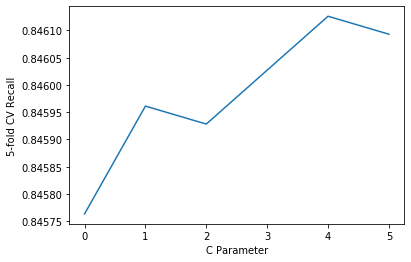

In [36]:
# Regulazierung , L2 mitschätzen kann -> L2 ist Bestrafungsterm in Abhängigkeit von unserem Lambda/alpha und nehme immer Beta^2

params={'alpha': np.arange(0,6,1) } # versuchen wir 6 verschiedene Lambdas/Alpha

ord_Logit_CV= mord.LogisticAT()

gs_ord_Logit = GridSearchCV(ord_Logit_CV, params, verbose=2, n_jobs=1, cv=5, scoring='accuracy') 
gs_ord_Logit.fit(np.asarray(X_train), np.asarray(y_train_OL).reshape(len(y_train_OL),))



plt.figure()
plt.plot(list(params.values ())[0],( gs_ord_Logit.cv_results_['mean_test_score']))
plt.xlabel('C Parameter')
plt.ylabel('5-fold CV Recall')
print('Best parameter: {}'.format((gs_ord_Logit.best_params_)))
print('Best score: {:.5f}'.format((gs_ord_Logit.best_score_ )))

# Klausur relevante Fragen:

# Frage: wie vele verschiedene Modelle müssen wir schätzen? wie viele Fits machen wir insgesamt?
# Antwort: Trainingsdaten sind in 5 Teile aufgesplittet * 6 Candidates für alpha/lambda = 30 -> ich würde 30 verschidene Modelle dann wähle ich ein Modell, dass höchste Accuracy hat

# Frage: Bedeutung von Lambda/Alpha?
# Antwort: je höhe dieses Alpha/Lambda ist, desto höhere ist die Regularizierung

# Frage: wie viele Lambdas wird geschätzt?
# Antwort: np.arange(0,6,1) return an array([0, 1, 2, 3, 4, 5]) of 6 elements -> 6 Lambdas!

In [34]:
# Plott für jedes C Parameter ist unsere Lambda 
# Links ist mittlere Accuracy für Cross-Validierung
# wenn der C/alpha/lambda=4 dann mittlere Accuracy(=5-fold-CV Recall) ist am besten

# wenn C=Lambda=0 (keine Regularizierung) das ist normales Logit Modell 
# Die Unterschied zwischen niedrigst und beste mittlere Accuracy = 0.8461 - 0.84575 = 0.00035 -> Regularizierung hat nicht zu viel gebracht


### Fit the optimized Model

In [37]:
Ord_logit_regular=mord.LogisticAT(alpha =gs_ord_Logit.best_params_['alpha'],verbose=1)
Ord_logit_regular.fit(np.asarray(X_train), np.asarray(y_train_OL).reshape(len(y_train_OL),))



Prediction_ORLogit_Reg_InSample=pd.Series(Ord_logit_regular.predict(np.asarray(X_train))).map({0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:"G"})
Prediction_ORLogit_Reg_OutSample=pd.Series(Ord_logit_regular.predict(np.asarray(X_test))).map({0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:"G"})

### Compare the Fit

In [38]:
print('Accuracy ORLogit Out of Sample: \n', accuracy_score(y_test,Prediction_ORLogit_OutSample),'\n\n')
print('Accuracy ORLogit with L2 Out of Sample: \n', accuracy_score(y_test,Prediction_ORLogit_Reg_OutSample),'\n\n')

# ich habe 0.0003 höhere Accuracy -> es lohnt sich nicht zu viel!

Accuracy ORLogit Out of Sample: 
 0.8456453883346594 


Accuracy ORLogit with L2 Out of Sample: 
 0.8459514046147255 




### Compare the coefficients
#### jetzt schauen wir die Veränderung von den Koeffizienten

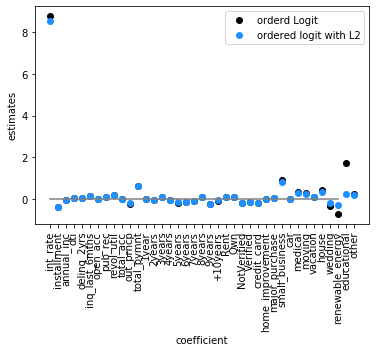

In [39]:
coef_Regular = pd.DataFrame(ord_Logit.coef_)
coef_Regular['CV']=Ord_logit_regular.coef_.reshape (39,1)
x=np.arange(0,39)
labels=X_train.columns.values
plt.plot(x,coef_Regular.iloc[:,0], 'bo',color = 'black')
plt.plot(x, coef_Regular.iloc[:,1], 'bo',color = 'dodgerblue')
plt.plot([0,36],[0,0],color='gray')
plt.xticks(x, labels , rotation='vertical')
plt.xlabel('coefficient')
plt.ylabel('estimates')
plt.legend(('orderd Logit', 'ordered logit with L2'),loc='upper right')

# man sieht, dass Schätzwerte der Koeffizienten nicht verändert worden sind -> Regularizierung muss nicht immer besser sein und muss nicht immer Einfluss haben! 

## Overall comparison

### Accuracy

In [40]:
print('Accuracy MNLogit Out of Sample     : ', accuracy_score(y_test,Prediction_MNLogit_OutSample))
print('Accuracy ORLogit Out of Sample     : ', accuracy_score(y_train,Prediction_ORLogit_InSample))
print('Accuracy ORLogit Out of Sample (L2): ', accuracy_score(y_test,Prediction_ORLogit_Reg_OutSample))



Accuracy MNLogit Out of Sample     :  0.788481547218312
Accuracy ORLogit Out of Sample     :  0.8469498731173583
Accuracy ORLogit Out of Sample (L2):  0.8459514046147255


### F1 score of lowest rating grade 'G'

In [41]:
Report_MNLogit=classification_report(y_test ,Prediction_MNLogit_OutSample,output_dict=True)
Report_ORLogit=classification_report(y_test ,Prediction_ORLogit_OutSample,output_dict=True)
Report_ORLogit_L2=classification_report(y_test ,Prediction_ORLogit_Reg_OutSample,output_dict=True)

print('Rating Grade G MNLogit Out of Sample     : ', Report_MNLogit['G']['f1-score'])
print('Rating Grade G ORLogit Out of Sample     : ', Report_ORLogit['G']['f1-score'])
print('Rating Grade G ORLogit Out of Sample (L2): ', Report_ORLogit_L2['G']['f1-score'])

Rating Grade G MNLogit Out of Sample     :  0.08108108108108109
Rating Grade G ORLogit Out of Sample     :  0.36904761904761907
Rating Grade G ORLogit Out of Sample (L2):  0.36904761904761907


### F1 score of second lowest rating grade 'F'

In [42]:
print('Rating Grade F MNLogit Out of Sample     : ', Report_MNLogit['F']['f1-score'])
print('Rating Grade F ORLogit Out of Sample     : ', Report_ORLogit['F']['f1-score'])
print('Rating Grade F ORLogit Out of Sample (L2): ', Report_ORLogit_L2['F']['f1-score'])

Rating Grade F MNLogit Out of Sample     :  0.20502901353965183
Rating Grade F ORLogit Out of Sample     :  0.3027210884353741
Rating Grade F ORLogit Out of Sample (L2):  0.29982964224872233
